In [1]:
import importlib
import os
from typing import Literal

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torch

import kitti
import plotting
import point_cloud
import img_utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
date = "2011_09_26"
drive = 2
cam: Literal[0, 1, 2, 3] = 2
frame = 0

# Image

In [4]:
data_path = kitti.data_path(date, drive)
image_data_path = kitti.image_data_path(date, drive, cam)
velodyne_data_path = kitti.velodyne_data_path(date, drive)
velodyne_path = kitti.velodyne_path(date, drive, frame)
img_path = kitti.image_path(date, drive, cam, frame)

print(f"Path of the dataset: {data_path}")
print(f"Path to images folder: {image_data_path}")
print(f"Path to the chosen image: {img_path}")
print(f"Path to velodyne folder: {velodyne_data_path}")
print(f"Path to the chosen velodyne file: {velodyne_path}")

Path of the dataset: /mnt/d/KITTI Dataset/2011_09_26/2011_09_26_drive_0002_sync
Path to images folder: /mnt/d/KITTI Dataset/2011_09_26/2011_09_26_drive_0002_sync/image_02/data
Path to the chosen image: /mnt/d/KITTI Dataset/2011_09_26/2011_09_26_drive_0002_sync/image_02/data/0000000000.png
Path to velodyne folder: /mnt/d/KITTI Dataset/2011_09_26/2011_09_26_drive_0002_sync/velodyne_points/data
Path to the chosen velodyne file: /mnt/d/KITTI Dataset/2011_09_26/2011_09_26_drive_0002_sync/velodyne_points/data/0000000000.bin


Using RGB image.
Image shape: (375, 1242, 3)


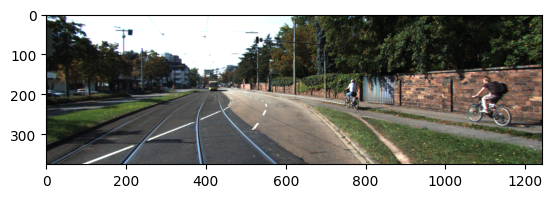

In [5]:
img = kitti.image(date, drive, cam, frame)

img_height, img_width = img.shape[0:2]
img_size = (img_height, img_width)

if img.ndim == 3:
    print("Using RGB image.")
else:
    print("Using grayscale image.")

print(f"Image shape: {img.shape}")

plotting.draw(img)

# Segmentation

In [6]:
from lang_sam import LangSAM

/home/metinersin/python-envs/heightest/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/metinersin/python-envs/heightest/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
# segmentation model

model = LangSAM()

/home/metinersin/python-envs/heightest/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/metinersin/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [8]:
mask = img_utils.segment(model, img, "ground", min_size_ratio=0.002)

/home/metinersin/python-envs/heightest/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/metinersin/python-envs/heightest/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/metinersin/python-envs/heightest/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


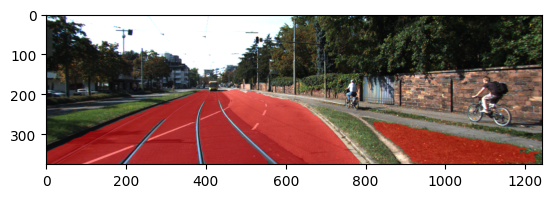

In [9]:
img_masked = img_utils.apply_mask(img, mask, alpha=0.5, color=(255, 0, 0))
plotting.draw(img_masked)

# Point Cloud

In [16]:
velo_to_cam, r_rect, p_rect = kitti.calib_data(date, cam)

print(f"Lidar coord. to camera coord. transformation matrix:")
print(velo_to_cam)
print()
print(f"Rectification matrix")
print(r_rect)
print()
print(f"Projection matrix:")
print(p_rect)
print()

Lidar coord. to camera coord. transformation matrix:
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

Rectification matrix
[[ 0.9999239   0.00983776 -0.00744505  0.        ]
 [-0.0098698   0.9999421  -0.00427846  0.        ]
 [ 0.00740253  0.00435161  0.9999631   0.        ]
 [ 0.          0.          0.          1.        ]]

Projection matrix:
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]



In [17]:
points_lidar = kitti.velodyne_data(date, drive, frame)
points_cam = point_cloud.lidar_to_cam(points_lidar, velo_to_cam=velo_to_cam)
points_img, idx = point_cloud.cam_to_img(
    points_cam, r_rect=r_rect, p_rect=p_rect, img_height=img_height, img_width=img_width
)

print(f"Shape of the points_lidar/points_cam matrix: {points_lidar.shape}")
print(f"Shape of the points_img matrix: {points_img.shape}")

num_points = points_lidar.shape[0]
num_points_in_img_plane = np.sum(idx)

print(
    f"There are {num_points} points in the point cloud. {num_points_in_img_plane} of them are inside the image plane."
)

Shape of the points_lidar/points_cam matrix: (121080, 3)
Shape of the points_img matrix: (121080, 2)
There are 121080 points in the point cloud. 19124 of them are inside the image plane.


(array([[609, 152],
        [608, 152],
        [605, 152],
        ...,
        [922, 528],
        [918, 527],
        [915, 527]]),
 array([ True,  True,  True, ..., False, False, False]))

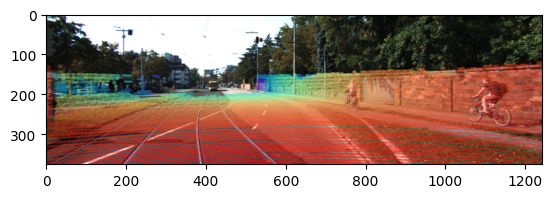

In [18]:
# draw the points on the image

point_cloud.draw_velodyne_on_image(
    img,
    points_lidar,
    velo_to_cam=velo_to_cam,
    r_rect=r_rect,
    p_rect=p_rect,
    alpha=0.2,
    size=1,
)

# Scale Field

In [19]:
scale_field_on_lidar = point_cloud.scale_field_on_lidar(
    points_lidar,
    img_size=img_size,
    velo_to_cam=velo_to_cam,
    r_rect=r_rect,
    p_rect=p_rect,
)
print(f"Shape of the scale field: {scale_field_on_lidar.shape}")

Shape of the scale field: (121080,)


In [20]:
scale_field_on_img = point_cloud.to_field_on_img(
    scale_field_on_lidar,
    points_lidar,
    mask=mask,
    interpolation="cubic",
    img_size=img_size,
    velo_to_cam=velo_to_cam,
    r_rect=r_rect,
    p_rect=p_rect,
)

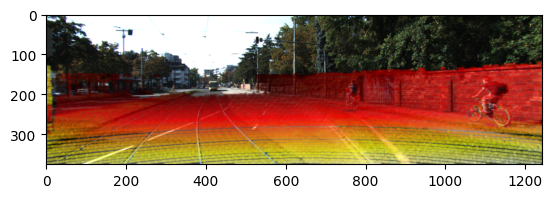

In [21]:
plotting.scatter_on_image(
    img, points_img[idx], c=scale_field_on_lidar[idx], alpha=0.2, cmap="hot"
)

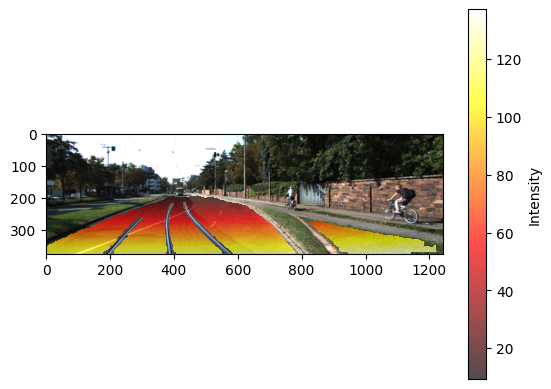

In [22]:
plotting.draw_field_on_image(scale_field_on_img, img, alpha=0.7)